# **Laporan Proyek Machine Learning - Syahel Rusfi Razaba**
*Webtoon Recommender System*

## **Import Library**
Mengimpor semua library Python yang dibutuhkan untuk menjalankan proyek, seperti `pandas` untuk manipulasi data, `numpy` untuk operasi numerik, `re` untuk ekspresi reguler, `TfidfVectorizer` dan `cosine_similarity` dari `sklearn` untuk pembuatan model rekomendasi, serta `matplotlib` dan `seaborn` untuk visualisasi data.

In [ ]:
# Import Library
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Library for text cleaning
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# Download stopwords (only needed once)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Load Dataset**
Membaca dataset `Webtoon Dataset.csv` yang berisi data terkait informasi Webtoon. Dataset ini memiliki beberapa fitur seperti Name, Writer, Likes, Genre, Rating, Subscribers, Summary, Update, id, dan Reading Link.

In [ ]:
# Load Dataset
df = pd.read_csv('https://github.com/syahelrusfi21/Webtoon-Recommendation-System/raw/main/dataset/Webtoon%20Dataset.csv')
print("Dimesnsi data:", df.shape)
df.head()

Dimesnsi data: (569, 10)


,id,Name,Writer,Likes,Genre,Rating,Subscribers,Summary,Update,Reading Link
0,0,Let's Play,Leeanne M. Krecic (Mongie),30.6M,Romance,9.62,4.2M,"She's young, single and about to achieve her d...",UP EVERY TUESDAY,https://www.webtoons.com/en/romance/letsplay/l...
1,1,True Beauty,Yaongyi,39.9M,Romance,9.60,6.4M,"After binge-watching beauty videos online, a s...",UP EVERY WEDNESDAY,https://www.webtoons.com/en/romance/truebeauty...
2,2,Midnight Poppy Land,Lilydusk,10.4M,Romance,9.81,2.1M,After making a grisly discovery in the country...,UP EVERY SATURDAY,https://www.webtoons.com/en/romance/midnight-p...
3,3,Age Matters,Enjelicious,25.9M,Romance,9.79,3.5M,She's a hopeless romantic who's turning 30's ...,UP EVERY WEDNESDAY,https://www.webtoons.com/en/romance/age-matter...
4,4,Unholy Blood,Lina Im / Jeonghyeon Kim,9.9M,Supernatural,9.85,1.5M,When vampires destroy her chance to have the n...,UP EVERY THURSDAY,https://www.webtoons.com/en/supernatural/unhol...


## **Data Understanding**
Dataset yang digunakan adalah Webtoon Dataset yang diperoleh dari [Kaggle](https://www.kaggle.com/datasets/swarnimrai/webtoon-comics-dataset).
### Informasi Dataset:
- Jumlah sampel: 569 baris (sebelum cleaning)
- Jumlah fitur: 10 fitur input

### Fitur:
| Fitur | Deskripsi |
| ------ | ------ |
| id | ID unik yang mengidentifikasi komik. |
| Name | Nama lengkap komik. |
| Writer | Penulis komik. |
| Likes | Total jumlah Like. |
| Genre | Genre komik. |
| Rating | Rata-rata rating komik dari skala 10. |
| Subscribers | Total jumlah Subscriber. |
| Summary | Ringkasan komik. |
| Update | Hari dalam seminggu untuk update. |
| Reading Link | Tautan di mana komik dapat dibaca. |

## **Data Preparation**
Bagian utama untuk membersihkan dan menyiapkan data sebelum digunakan dalam tahap model development.

### **Data Cleaning**
Menghapus kolom yang tidak relevan (`id` dan `Reading Link`), memeriksa informasi dataset (`df.info()`), mengonversi kolom `Likes` dan `Subscribers` menjadi tipe data numerik dengan menangani akhiran 'K', 'M', dan 'B', memeriksa data duplikat, dan menangani missing value dengan menghapus baris yang memiliki missing value.

In [ ]:
# Drop irrelevant columns
df = df.drop(['id', 'Reading Link'], axis=1)
print("Kolom setelah dihapus:")
df.head()

Kolom setelah dihapus:


,Name,Writer,Likes,Genre,Rating,Subscribers,Summary,Update
0,Let's Play,Leeanne M. Krecic (Mongie),30.6M,Romance,9.62,4.2M,"She's young, single and about to achieve her d...",UP EVERY TUESDAY
1,True Beauty,Yaongyi,39.9M,Romance,9.60,6.4M,"After binge-watching beauty videos online, a s...",UP EVERY WEDNESDAY
2,Midnight Poppy Land,Lilydusk,10.4M,Romance,9.81,2.1M,After making a grisly discovery in the country...,UP EVERY SATURDAY
3,Age Matters,Enjelicious,25.9M,Romance,9.79,3.5M,She's a hopeless romantic who's turning 30's ...,UP EVERY WEDNESDAY
4,Unholy Blood,Lina Im / Jeonghyeon Kim,9.9M,Supernatural,9.85,1.5M,When vampires destroy her chance to have the n...,UP EVERY THURSDAY


In [ ]:
# Dataset Information
print("Informasi Dataset:")
df.info()

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         569 non-null    object 
 1   Writer       568 non-null    object 
 2   Likes        569 non-null    object 
 3   Genre        569 non-null    object 
 4   Rating       569 non-null    float64
 5   Subscribers  569 non-null    object 
 6   Summary      569 non-null    object 
 7   Update       569 non-null    object 
dtypes: float64(1), object(7)
memory usage: 35.7+ KB


In [ ]:
def convert_to_numeric(value):
    """Converts a string representation of a number with K, M, or B suffixes to a numeric value,
       handling both comma and period as decimal separators, and commas as thousands separators."""
    value = str(value).strip().upper() # Convert to uppercase for consistent handling

    # Remove commas used as thousands separators
    value = value.replace(',', '')

    multiplier = 1
    if 'B' in value:
        value = value.replace('B', '')
        multiplier = 1_000_000_000
    elif 'M' in value:
        value = value.replace('M', '')
        multiplier = 1_000_000
    elif 'K' in value:
        value = value.replace('K', '')
        multiplier = 1_000

    try:
        # Use float() first to handle potential decimal points before converting to int
        return int(float(value) * multiplier)
    except ValueError:
        return 0 # Return 0 or NaN for values that can't be converted


df['Likes'] = df['Likes'].apply(convert_to_numeric).astype(int)
df['Subscribers'] = df['Subscribers'].apply(convert_to_numeric).astype(int)

print("Tipe data setelah konversi:")
print(df[['Likes', 'Subscribers']].dtypes)
df.head()

Tipe data setelah konversi:
Likes          int64
Subscribers    int64
dtype: object


,Name,Writer,Likes,Genre,Rating,Subscribers,Summary,Update
0,Let's Play,Leeanne M. Krecic (Mongie),30600000,Romance,9.62,4200000,"She's young, single and about to achieve her d...",UP EVERY TUESDAY
1,True Beauty,Yaongyi,39900000,Romance,9.60,6400000,"After binge-watching beauty videos online, a s...",UP EVERY WEDNESDAY
2,Midnight Poppy Land,Lilydusk,10400000,Romance,9.81,2100000,After making a grisly discovery in the country...,UP EVERY SATURDAY
3,Age Matters,Enjelicious,25900000,Romance,9.79,3500000,She's a hopeless romantic who's turning 30's ...,UP EVERY WEDNESDAY
4,Unholy Blood,Lina Im / Jeonghyeon Kim,9900000,Supernatural,9.85,1500000,When vampires destroy her chance to have the n...,UP EVERY THURSDAY


In [ ]:
# Check for duplicate data
print("Jumlah data duplikat:", df.duplicated().sum())

Jumlah data duplikat: 0


In [ ]:
# Check for missing values
print("Jumlah missing value per kolom:")
print(df.isnull().sum())
print("Dimesnsi data:", df.shape)

Jumlah missing value per kolom:
Name           0
Writer         1
Likes          0
Genre          0
Rating         0
Subscribers    0
Summary        0
Update         0
dtype: int64
Dimesnsi data: (569, 8)


In [ ]:
# Remove missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print("Jumlah missing value setelah dihapus:")
print(df.isnull().sum())
print("Dimesnsi data:", df.shape)

Jumlah missing value setelah dihapus:
Name           0
Writer         0
Likes          0
Genre          0
Rating         0
Subscribers    0
Summary        0
Update         0
dtype: int64
Dimesnsi data: (568, 8)


### **Exploratory Data Analysis**
Pada tahap ini, akan dieksplorasi terkait distribusi dan karakteristik data, seperti ringkasan statistik kolom numerik, distribusi Webtoon berdasarkan Genre, Distribusi Webtoon berdasarkan Jadwal Update, dan visualisasi outlier menggunakan Boxplot.

In [ ]:
# Summary of descriptive statistics
print("Ringkasan Statistik Kolom Numerik:")
display(df[['Likes', 'Rating', 'Subscribers']].describe())

Ringkasan Statistik Kolom Numerik:


,Likes,Rating,Subscribers
count,5.680000e+02,568.000000,5.680000e+02
mean,3.243530e+06,9.418644,4.821283e+05
std,6.388215e+06,0.557998,6.825991e+05
min,2.434000e+03,5.410000,5.400000e+03
25%,2.337772e+05,9.310000,1.147250e+05
50%,8.955880e+05,9.580000,2.560000e+05
75%,3.000000e+06,9.730000,5.631750e+05
max,5.060000e+07,9.930000,6.400000e+06


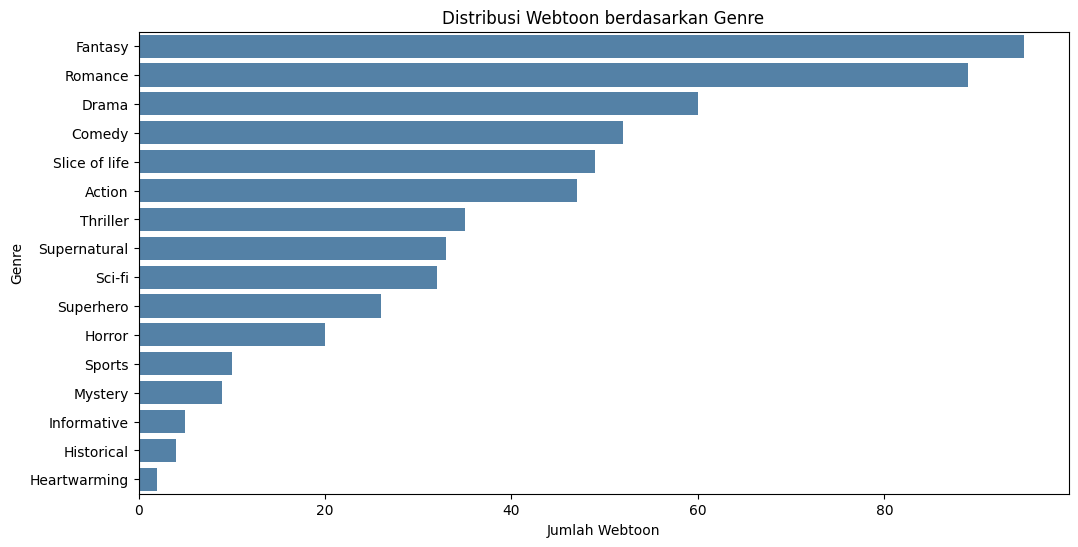

In [ ]:
# Distribution of Genre
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Genre', order=df['Genre'].value_counts().index, color='steelblue')
plt.title('Distribusi Webtoon berdasarkan Genre')
plt.xlabel('Jumlah Webtoon')
plt.ylabel('Genre')
plt.show()

Dari plot distribusi `Genre`, terlihat bahwa:

- Genre Fantasy, Romance, dan Drama memiliki jumlah Webtoon (komik) paling banyak berdasarkan sampel data dalam proyek ini. Hal ini
mengindikasikan bahwa genre tersebut memang banyak ditulis oleh para author. Bisa jadi hal ini karena cerita bergenre fantasy, romance, atau drama lebih laku di pasaran, memiliki peminat yang tinggi, atau jalan ceritanya cenderung lebih ringan ketimbang genre lainnya, sehingga lebih banyak author yang memilih untuk menulis cerita-cerita tersebut.
- Lalu genre seperti historical dan informative, cenderung sedikit jumlah komiknya. Ini menguatkan asumsi saya kalau memang jalan cerita terkait genre ini cenderung lebih sulit dan perlu fokus dan riset mendalam selama penulisannya.

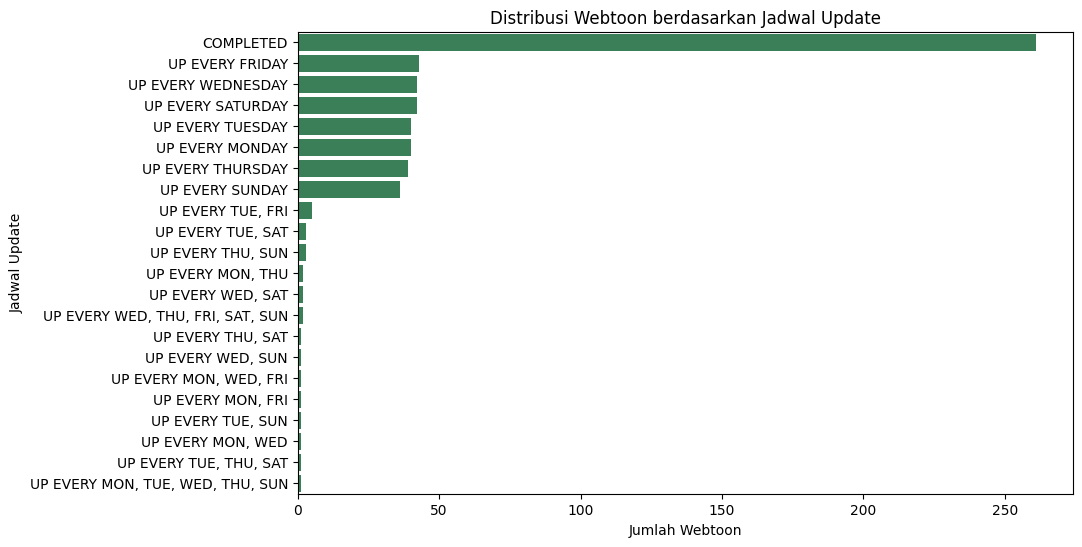

In [ ]:
# Distribution of Update
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Update', order=df['Update'].value_counts().index, color='seagreen') # Using a single color
plt.title('Distribusi Webtoon berdasarkan Jadwal Update')
plt.xlabel('Jumlah Webtoon')
plt.ylabel('Jadwal Update')
plt.show()

Berdasarkan distribusi `Update`, sebagian besar komik Webtoon dari sampel dataset ini merupakan komik yang sudah selesai (*completed*). Selain itu, komik yang masih berlanjut (*ongoing*) rata-rata update per-minggu seperti tiap hari Jumat, Rabu, atau Sabtu. Lalu, ada yang menarik juga bahwa ternyata ada komik yang updatenya cukup sering, yakni setiap hari Senin, Selasa, Rabu, Kamis, dan Minggu, namun jumlahnya hanya sedikit.

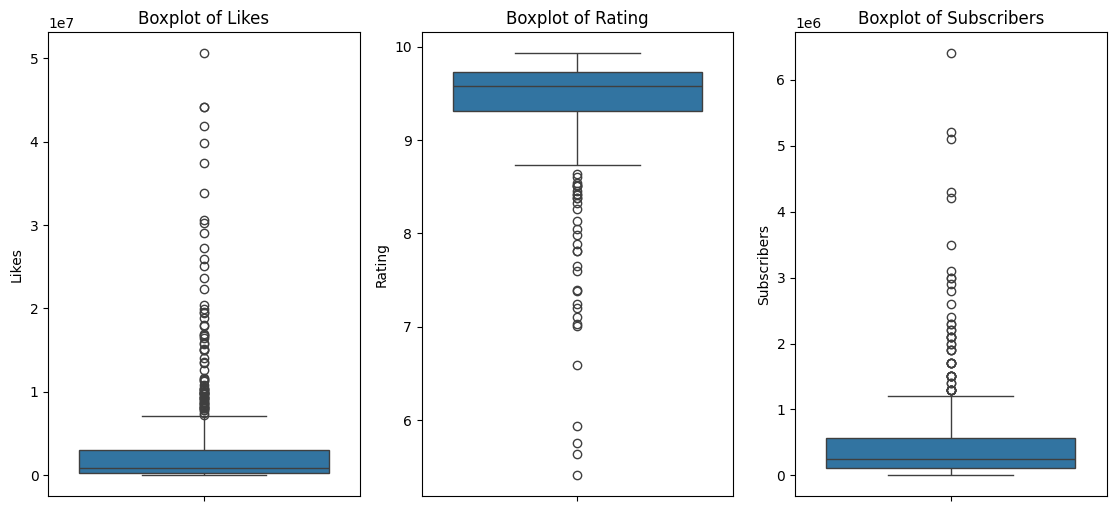

In [ ]:
# Distribution of numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1) # Adjust the grid based on the number of numerical columns
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Terlihat bahwa distribusi data numerik tidak terdistribusi secara normal (cenderung skewed) dan terdapat banyak outlier. Untuk menangani outlier ini, kita akan menggunakan metode transformasi yang dikenal sebagai **Winsorization** (atau Capping).

Dengan metode ini, nilai-nilai ekstrem (outlier) tidak dihapus, melainkan dibatasi atau "dicapping". Nilai-nilai yang berada di atas batas atas (Q3 + 1.5 * IQR) akan diganti dengan nilai batas atas tersebut, sementara nilai-nilai yang berada di bawah batas bawah (Q1 - 1.5 * IQR) akan diganti dengan nilai batas bawah.

Pendekatan Winsorization dipilih untuk mempertahankan jumlah data asli sambil mengurangi pengaruh nilai-nilai yang sangat ekstrem pada analisis dan model.

### **Data Pre-Processing**
Pada tahap ini, akan dilakukan transformasi data variabel numerik menggunakan **Winsorization** untuk menangani outlier.

In [ ]:
# Copy original data
df_transformed = df.copy()

# List numerical features (extract all numeric columns from df_transformed)
numerical_features = df_transformed.select_dtypes(include=np.number).columns

# Winsorization: Limit outlier values to IQR boundaries
for col in numerical_features:
    Q1 = df_transformed[col].quantile(0.25)
    Q3 = df_transformed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_transformed[col] = np.where(df_transformed[col] < lower_bound, lower_bound,
                            np.where(df_transformed[col] > upper_bound, upper_bound, df_transformed[col]))

df_transformed.head()

,Name,Writer,Likes,Genre,Rating,Subscribers,Summary,Update
0,Let's Play,Leeanne M. Krecic (Mongie),7149334.125,Romance,9.62,1235850.0,"She's young, single and about to achieve her d...",UP EVERY TUESDAY
1,True Beauty,Yaongyi,7149334.125,Romance,9.60,1235850.0,"After binge-watching beauty videos online, a s...",UP EVERY WEDNESDAY
2,Midnight Poppy Land,Lilydusk,7149334.125,Romance,9.81,1235850.0,After making a grisly discovery in the country...,UP EVERY SATURDAY
3,Age Matters,Enjelicious,7149334.125,Romance,9.79,1235850.0,She's a hopeless romantic who's turning 30's ...,UP EVERY WEDNESDAY
4,Unholy Blood,Lina Im / Jeonghyeon Kim,7149334.125,Supernatural,9.85,1235850.0,When vampires destroy her chance to have the n...,UP EVERY THURSDAY


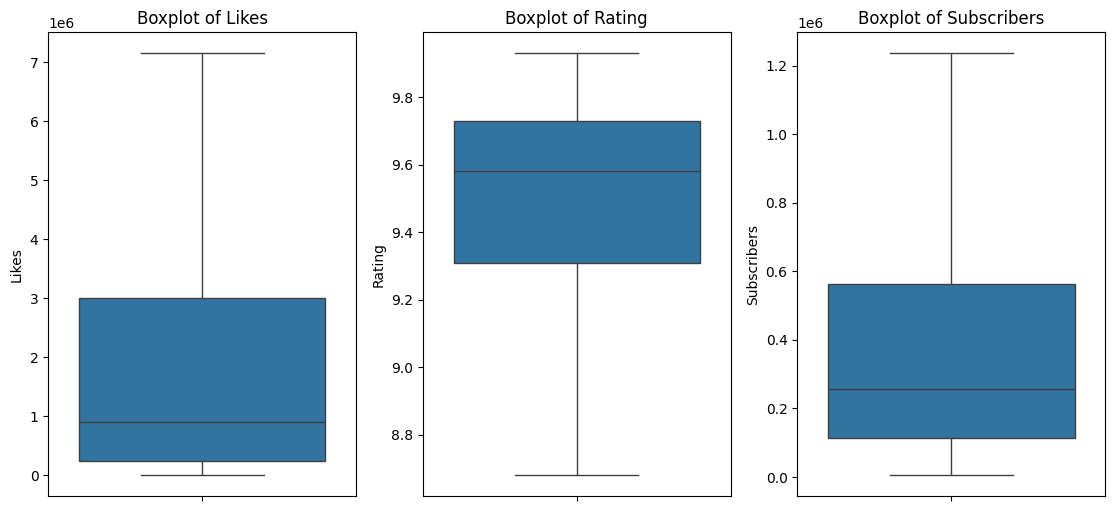

In [ ]:
# Outlier visualization with Boxplot after transformation
numerical_cols_transformed = df_transformed.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_transformed):
    plt.subplot(2, 4, i + 1) # Adjust the grid based on the number of numerical columns
    sns.boxplot(y=df_transformed[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Setelah proses transformasi, terlihat bahwa outlier telah berhasil dihilangkan. Oleh karena itu, dataset ini sudah cukup bersih untuk digunakan dalam tahap modeling atau analisis lanjutan. Namun, dalam proyek ini, karena akan menerapkan pendekatan **Content-Based Filtering**, dataset asli sebelum transformasi tetap digunakan. Hal ini dikarenakan hanya kolom `Summary`, `Genre`, dan `Name` (judul Webtoon) yang akan dimanfaatkan dalam sistem rekomendasi.

Text pre-processing

In [ ]:
# Combine summary and genre
df['Content'] = df['Summary'] + ' ' + df['Genre']

# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Complete text preprocessing function
def clean_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    words = text.split()  # tokenize

    # remove stopwords and apply stemming
    words = [stemmer.stem(word) for word in words if word not in stop_words]

    return ' '.join(words)

# Apply the preprocessing to the dataset
df['Content_Clean'] = df['Content'].apply(clean_text)

Vektorisasi dengan TF-IDF

In [ ]:
# Initialize vectorizer and create TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['Content_Clean'])

# Compute cosine similarity between all webtoons
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a quick search index from titles
indices = pd.Series(df.index, index=df['Name'].str.lower())

## **Model Development dengan Content-Based Filtering**
Pada tahap ini, akan dibuat sistem rekomendasi berbasis konten, yakni berdasarkan genre dan ringkasan komik.

In [ ]:
# Recommendation system function with cosine similarity score

def recommend_webtoons(title, top_n=5):
    title_lower = title.lower()

    # Check if the title exists in the index
    if title_lower not in indices:
        return f"Webtoon '{title}' tidak ditemukan."

    idx = indices[title_lower]

    # Calculate similarity scores and sort them
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Extract top N recommendations (skip the first one because it's the input itself)
    top_sim_scores = sim_scores[1:top_n+1]
    webtoon_indices = [i[0] for i in top_sim_scores]
    similarity_values = [i[1] for i in top_sim_scores]

    # Data of the searched title
    input_webtoon = df.iloc[[idx]][['Name', 'Genre', 'Summary']].copy()
    input_webtoon['Keterangan'] = 'Judul yang dicari'
    input_webtoon['Similarity'] = 1.0  # Similarity terhadap dirinya sendiri = 1

    # Recommended webtoons data
    recommended = df.iloc[webtoon_indices][['Name', 'Genre', 'Summary']].copy()
    recommended['Keterangan'] = 'Rekomendasi'
    recommended['Similarity'] = similarity_values

    # Combine results
    result = pd.concat([input_webtoon, recommended], ignore_index=True)

    # Optional: Urutkan kembali berdasarkan skor similarity jika diperlukan
    result = result.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

    return result

# Apply the Webtoon Recommendation System
recommend_webtoons("Lookism", top_n=5)

,Name,Genre,Summary,Keterangan,Similarity
0,Lookism,Drama,Daniel is an unattractive loner who wakes up i...,Judul yang dicari,1.000000
1,Fluidum,Drama,Jesse was born like every citizen in the Fluid...,Rekomendasi,0.130963
2,Warning Label,Romance,"Danielle was cursed by an ex-boyfriend, and no...",Rekomendasi,0.130699
3,Denma,Sci-fi,Dike the Invincible Death is the #1 target for...,Rekomendasi,0.112257
4,City of Walls,Drama,Welcome to the prison-like city of Kowloon. A ...,Rekomendasi,0.102767
5,My Life as a Loser,Drama,My life was ruined after you bullied me in hig...,Rekomendasi,0.093179


## **Evaluation**
Dalam proyek ini, tidak tersedia data interaksi pengguna untuk melakukan evaluasi kuantitatif menggunakan metrik seperti Precision@K atau Recall@K. Oleh karena itu, evaluasi dilakukan secara **kualitatif**, dengan cara menilai sejauh mana hasil rekomendasi yang dihasilkan oleh sistem terasa relevan berdasarkan isi dan genre Webtoon.

Sistem menggunakan **Cosine Similarity** pada tahap modeling untuk mengukur kemiripan antar Webtoon berdasarkan deskripsi dan genre. Namun perlu dicatat bahwa **Cosine Similarity bukan metrik evaluasi**, melainkan hanya digunakan sebagai dasar untuk menentukan item yang direkomendasikan.

Untuk menilai kualitas hasil, dilakukan analisis terhadap beberapa contoh rekomendasi, misalnya:

- Input: `Lookism`, sebuah Webtoon bertema drama dan kehidupan sekolah.
- Rekomendasi yang muncul seperti `Fluidum`, `City of Walls`, dan `My Life as a Loser`, secara umum masih mengandung elemen-elemen cerita personal, drama, dan konflik sosial, yang membuatnya cukup relevan dari segi konten.

Dengan demikian, meskipun sistem tidak dievaluasi secara kuantitatif, evaluasi kualitatif menunjukkan bahwa pendekatan *content-based* mampu memberikan hasil yang masuk akal dan relevan.

## **Kesimpulan**
Proyek ini berhasil membangun sistem rekomendasi Webtoon menggunakan pendekatan *Content-Based Filtering* dengan *Cosine Similarity* untuk menentukan kemiripan antar judul berdasarkan genre dan ringkasan cerita.

Meskipun nilai kemiripan relatif rendah secara numerik, sistem tetap mampu menghasilkan urutan rekomendasi yang secara kualitatif dinilai relevan. Evaluasi dilakukan secara kualitatif karena tidak tersedia data interaksi pengguna, dan hasilnya menunjukkan bahwa sistem dapat membantu pengguna menemukan Webtoon lain yang serupa dengan minat awalnya.

Pendekatan ini cocok digunakan dalam kondisi terbatas seperti pada dataset ini, dan dapat dikembangkan lebih lanjut dengan *Collaborative Filtering* atau metrik evaluasi kuantitatif jika tersedia data tambahan di masa mendatang.